# Milestone 2 Phase 2
Name: Judan Syamsul Hadad

Batch: FTDS-009

## 1. Introduction

Welcome. 

This notebook is made to fulfill learning goals of <u>**Full Time Data Science (FTDS) Bootcamp Batch 9**</u> by Hacktiv8 in which the author, **Judan Syamsul Hadad** also known as **Riezn**, is one of the participant.

The dataset used in this notebook can be downloaded [here](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification). This dataset contains tweets regarding COVID-19 which was scraped from twitter. The dataset contains the following information:
- Location where the tweet was posted, e.g. London
- Date when the tweet was posted, e.g. 2020-03-01
- Content of the tweet, e.g. "I am feeling sick #covid19"
- Sentiment of the tweet (extremely negative, negative, neutral, positive, extremely positive)

The model deployment can be found [here](https://covid-sentiment-ftds009.herokuapp.com/).

### 1.1. Goal

Through sentiment analysis, we can infer certain behavior tendency from tweets posted by user.

For example, positive tweets might come from someone who feel happy getting to work from home, while negative tweet might come from someone who is upset because they can't buy basic necessities due to panic buying.

The resulting model can be used to check user sentiment towards new government policy regarding Covid-19 which we will try for model inference.

### 1.2. Method

This notebook will cover the following steps:
1. Exploratory Data Analysis (EDA)
2. Data Preprocessing:
    - Data Splitting:
    - Text Cleaning
    - Target Labeling
    - Preprocessing Pipeline
    - Tensorflow Input Pipeline
3. Model Definition:
    - Early Stopping
    - Text Vectorization
    - Word Embedding
    - Layers
4. Model Training
5. Model Evaluation
    - Baseline Model Evaluation
    - Model Improvement: LSTM/GRU
    - Model Improvement: Reducing Hidden Neuron
    - Model Improvement: Dropout
    - Model Analysis
    - Model Saving
6. Model Inference
7. Conclusion

### 1.3. Problem Statement

How does the model look like to predict the general populace's respond to COVID-19 and what are the defining features of the model?

## 2. Import Libraries

In [6]:
#general
import numpy as np 
import pandas as pd
import warnings
import pickle
import random
warnings.filterwarnings('ignore')
from string import punctuation
import re, string
from collections import defaultdict

#visualization
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

#word processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

#tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, TextVectorization, Embedding, LSTM, GRU, Dropout, SimpleRNN

#validation and evaluation
from sklearn.metrics import classification_report

## 3. Data Loading

Before proceeding further, let's define the random state and seed for the whole notebook so we can reproduce certain parts of the notebook.

In [7]:
random_state = 34
random.seed = random_state
np.random.seed = random_state
tf.random.set_seed(random_state)

The next few lines would be all technical so we can read the notebook a little bit more comfortable.

Set pandas to display all columns.

In [8]:
pd.set_option('display.max_columns', None)

Since the dataset is already separated into train and test set, load both dataset.

In [9]:
# data_train = pd.read_csv('Corona_NLP_train.csv')
# data_test = pd.read_csv('Corona_NLP_test.csv')

The above code will result in encoding error. The default encoding for pandas read_csv is 'UTF-8' while these csv files use Latin-1 encoding which we need to state in the syntax. Let's reload the data, but this time set the encoding to `Latin-1`.

In [10]:
data_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
data_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')

To prevent modification to the original dataset, let's copy the dataframe to a new variable.

In [11]:
df_train = data_train.copy()
df_test = data_test.copy()

Now we have loaded the dataset properly. We will merge both dataset into one dataframe for initial data check and exploratory data analysis. Later during preprocessing we will use the initial split between train set and test set.

In [12]:
df = pd.concat([df_train, df_test], axis=0).reset_index()
df.shape

(44955, 7)

Let's see the top 5 rows of the dataframe.

In [13]:
df.head()

index  UserName  ScreenName   Location     TweetAt  \
0      0      3799       48751     London  16-03-2020   
1      1      3800       48752         UK  16-03-2020   
2      2      3801       48753  Vagabonds  16-03-2020   
3      3      3802       48754        NaN  16-03-2020   
4      4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

We have already found missing values at the top 5 rows in the `Location` column. Also, the username and screenname have been masked with numbers to maintain privacy of the user. 

Now let's check the dataset properties.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          44955 non-null  int64 
 1   UserName       44955 non-null  int64 
 2   ScreenName     44955 non-null  int64 
 3   Location       35531 non-null  object
 4   TweetAt        44955 non-null  object
 5   OriginalTweet  44955 non-null  object
 6   Sentiment      44955 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.4+ MB


Four columns are identified as `object` data type. Since we know that `Sentiment` is categorical data, we will convert it to `category` data type to conserve memory. While for `TweetAt` we will redefine the value as date format adhering to `%d-%m-%Y`.

In [15]:
df['Sentiment'] = df['Sentiment'].astype('category')
df['TweetAt'] = pd.to_datetime(df['TweetAt'], format='%d-%m-%Y').dt.date
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   index          44955 non-null  int64   
 1   UserName       44955 non-null  int64   
 2   ScreenName     44955 non-null  int64   
 3   Location       35531 non-null  object  
 4   TweetAt        44955 non-null  object  
 5   OriginalTweet  44955 non-null  object  
 6   Sentiment      44955 non-null  category
dtypes: category(1), int64(3), object(3)
memory usage: 2.1+ MB


We have successfully changed the data type to `category`. Let's check the number of unique values for each feature.

In [16]:
df.nunique()

index            41157
UserName         44955
ScreenName       44955
Location         13127
TweetAt             44
OriginalTweet    44955
Sentiment            5
dtype: int64

Now there are some columns that have as much unique values as the number of rows.

Here are some things that we can infer:
- `UserName`, `ScreenName`, and `OriginalTweet` are all unique values and not a single user is recorded twice in the dataset, however we do not know if there are retweets included in the dataset or not which need to be checked later on
- `Location` in actual is a high cardinal categorical feature, this  might be due to the fact that the tweets are scraped from all over the world
- `Sentiment` only have five unique values as stated in introduction from extremely negative to extremely positive

Let's make sure that there are no retweets included.

In [17]:
[x for x in df['OriginalTweet'] if x.startswith('RT')]

[]

There are none that we can find. Let's move on to check the statistical quality of the dataset.

In [18]:
df[['Location', 'TweetAt', 'OriginalTweet', 'Sentiment']].describe(include='all').T

count unique  \
Location       35531  13127   
TweetAt        44955     44   
OriginalTweet  44955  44955   
Sentiment      44955      5   

                                                             top   freq  
Location                                           United States    603  
TweetAt                                               2020-03-20   3448  
OriginalTweet  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...      1  
Sentiment                                               Positive  12369

Based on the table above, we can summarize the following:
- Most occurring location is `United States`
- The day with most tweets is 20 March 2020
- No duplicated tweet
- Majority of the sentiment is `Positive`, but the number is not that far from the average of count of `Sentiment` (roughly 9000)

We will explore it more in EDA to find any other values that follow up the most frequent value for each feature above.

## 4. Exploratory Data Analysis (EDA)

Now we get to play with the data. We have some homeworks from the previous section, but first let's check the distribution of `Sentiment`.

### 4.1. Sentiment Distribution

To get a good grasp of how the `Sentiment` is distributed, let's make a pie chart.

In [19]:
px.pie(df['Sentiment'].value_counts().reset_index(), values='Sentiment', names='index', title='Sentiment', width=500, height=400, hole=0.5)

The `Sentiment` distribution looks balanced enough.

Not one `Sentiment` have more than three times the percentage of other `Sentiment`.

### 4.2. Tweet Count by Location

Next let's find out which location most of the tweets originate from.

In [20]:
fig = px.bar(df['Location'].value_counts().reset_index()[0:11], x='index', y='Location', title='Tweet Count by Location', width=1000, height=500)
fig.update_layout(yaxis_title="Count", xaxis_title="Location")

Somehow countries and cities are mixed in as the `Location`. If we look more closely, there are cities in the same country that are stated separately such as `New York`, `Washington DC`, and `Los Angeles` in which all three are actually located in the `United States of America`. Even moreso, there are even redundant instances of the country with different naming such as `United States` and `USA`.

### 4.3. Tweet Count by Date


Earlier we know that 20 March 2020 is the day that has the most tweet, so let's check the tweet count along the timespan of the dataset.

In [21]:
fig = px.area(df['TweetAt'].value_counts().reset_index(), x='index', y='TweetAt', title='Tweet Count by Date', width=1000, height=500)
fig.update_layout(yaxis_title="Count", xaxis_title="Date")

The tweet about coronavirus starts gaining traction on 9 March 2020. Based on some simple research by the author, it was roughly one week after confirmed cases started popping up everywhere in the world and then on the twentieth the number of confirmed cases already skyrocketed from thousands to hundred of thousands.

### 4.4. Most Common Words

Now let's explore more on the content of the tweet itself.

We know that coronavirus and its derivative terms (covid, pandemic, etc.) will definitely be the most recurring words in the dataset. Outside of that, let's find out what other words are most common in the dataset.

Define the stopwords and text cleaning function.

In [22]:
stop_words = list(set(stopwords.words('english')))
spec_words = ['corona', 'virus', 'covid', 'disease', 
                'pandemic', 'coronavirus', 'coronacrisis', 
                'coronaviruspandemic', 'coronavirusoutbreak', 
                'coronavirusupdate', 'covidpandemic', 'covidupdate', 
                'covidoutbreak'] #words pertaining to covid-19
swords = stop_words + spec_words

In [23]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() #lowercase
    text = re.sub(r'http\S+', '', text) #remove hyperlink
    text = re.sub(r'#', '', text) #remove only the hash but not the word tag
    text = re.sub(r'@\w+', '', text) #remove mention
    text = re.sub(r'\d+', '', text) #remove number
    text = re.sub(r'\n', ' ', text) #remove new line
    text = re.sub(r'\r', ' ', text) #remove carriage return
    text = re.sub(r'[^\x00-\x7f]', '', text) #remove non utf8/ascii characters
    text = text.split() #split to words
    text = ' '.join([word for word in text if word not in stop_words]) #rejoin words without stopwords
    text = text.translate(str.maketrans('', '', string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§')) #remove punctuation
    text = text.split() #split to words
    text = ' '.join([word for word in text if word not in spec_words]) #rejoin words without stopwords
    text = text.strip() #remove empty space
    return text

Let's check one such example of the clean_text function.

In [24]:
df['OriginalTweet'][7]

"Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ"

In [25]:
clean_text(df['OriginalTweet'][7])

'supermarket today buy toilet paper rebel toiletpapercrisis'

We see that the stopwords, punctuations, hash, and some other stuffs have been removed as defined in the function and the context of the tweet has changed because the tweet no longer contains the word `don't`. There is both upside and downside to text cleaning which will be explained in data preprocessing section. 

Now we have the function to clean the text, create the collection of words from all available tweets.

In [26]:
#collect the words for word cloud
df['words'] = df['OriginalTweet'].apply(lambda x: clean_text(x))
df['words'] = df['words'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in swords])).apply(lambda x: x.split())
words = [x for x in df['words'] for x in x]

Now that we have all the necessary items, we can create the wordcloud to find out which words occur the most.

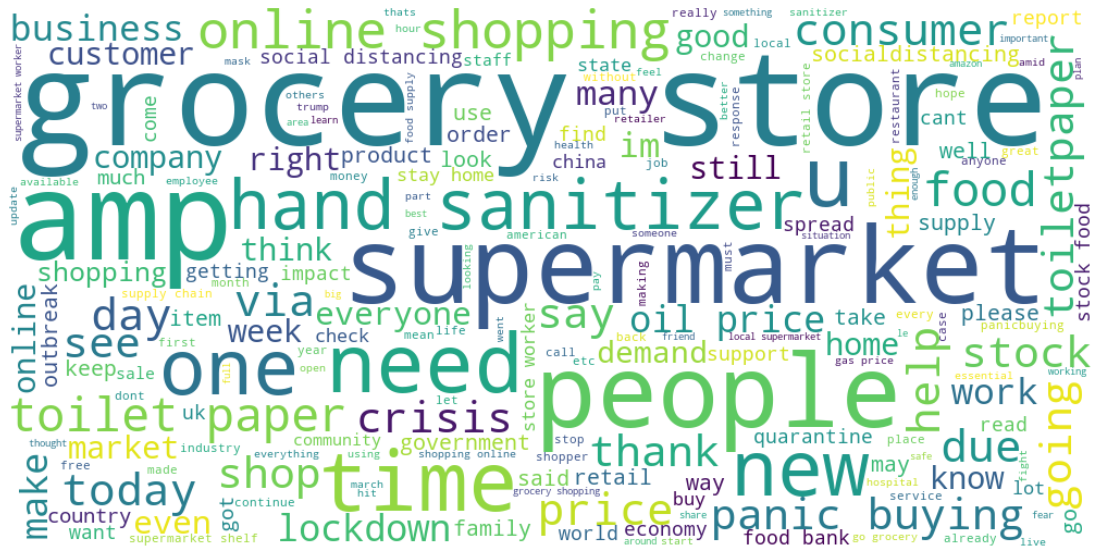

In [27]:
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                        random_state=random_state, relative_scaling=0.5).generate(' '.join(words))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.grid(False)
plt.axis('off')
plt.show()

Seems like in general people are tweeting about groceries and disease prevention items such as hand sanitizer. There are also some mentions regarding economy, stock, lockdown, and quarantine. There is an unknown word `amp`. This might refer to the institution `Association for Molecular Pathology`, just your normal amplifier, or even some stopwords from other languages. Let's check the tweet containing the word `amp`.

In [28]:
df[df['OriginalTweet'].str.contains('amp')]['OriginalTweet'].iloc[0]

'@7SealsOfTheEnd Soon with dwindling supplies unlawful Panicky people will be breaking into Closed Stores &amp; Supermarkets to Raid them as they normally do during a Crisis so massive as the #Coronavirus\r\r\n\r\r\n#StockUp&amp;LockUp'

Apparently `&amp;` in HTML is equal to `&`. This is due to how HTML works and translated poorly to the raw string of tweet. Also because the punctuations are removed so it looks like a proper word or named entity `amp`.

Let's add it to the local stopword list `spec_words` just in case.

In [29]:
spec_words.append('amp')
spec_words.append('&amp;')
swords.append('amp')
swords.append('&amp;')

Let's check the word cloud for each sentiment.

In [30]:
#create word collection for each sentiment
words_expos = [x for x in df[df['Sentiment']=='Extremely Positive']['words'] for x in x if x not in swords]
words_pos = [x for x in df[df['Sentiment']=='Positive']['words'] for x in x if x not in swords]
words_neu = [x for x in df[df['Sentiment']=='Neutral']['words'] for x in x if x not in swords]
words_neg = [x for x in df[df['Sentiment']=='Negative']['words'] for x in x if x not in swords]
words_exneg = [x for x in df[df['Sentiment']=='Extremely Negative']['words'] for x in x if x not in swords]

Starting from `Extremely Positive`.

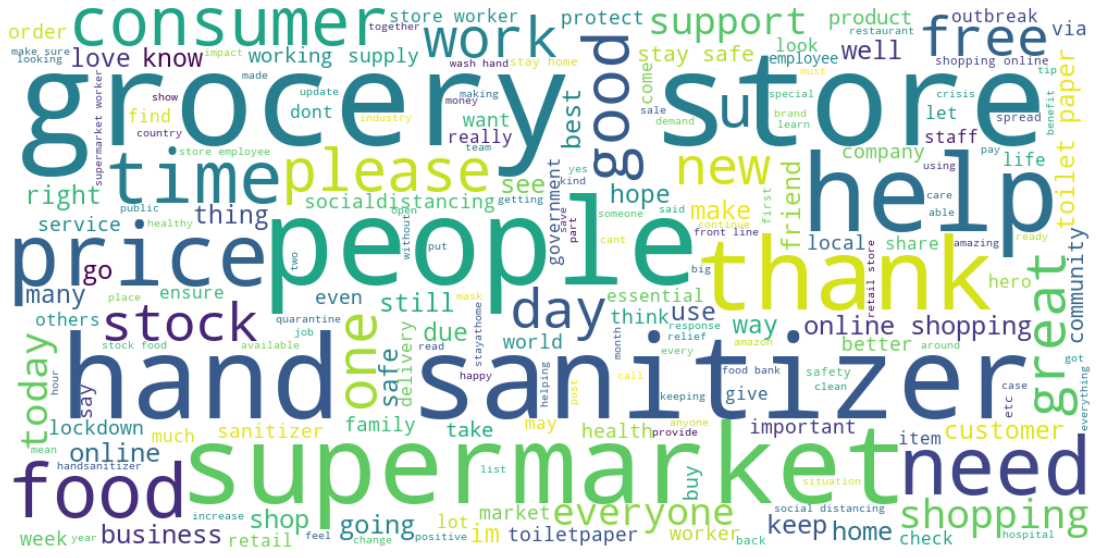

In [31]:
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                        random_state=random_state, relative_scaling=0.5).generate(' '.join(words_expos))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.grid(False)
plt.axis('off')
plt.show()

There are new words that are popping up in the word cloud like `thank`, `help` that might depict people thanking others for their help.

In [32]:
df[df['Sentiment']=='Extremely Positive']['OriginalTweet'].iloc[1]

'#horningsea is a caring community. LetÂ\x92s ALL look after the less capable in our village and ensure they stay healthy. Bringing shopping to their doors, help with online shopping and self isolation if you have symptoms or been exposed to somebody who has. https://t.co/lsGrXXhjhh'

The tweet talks about how people are helping each other. Now let's check the `Positive` one.

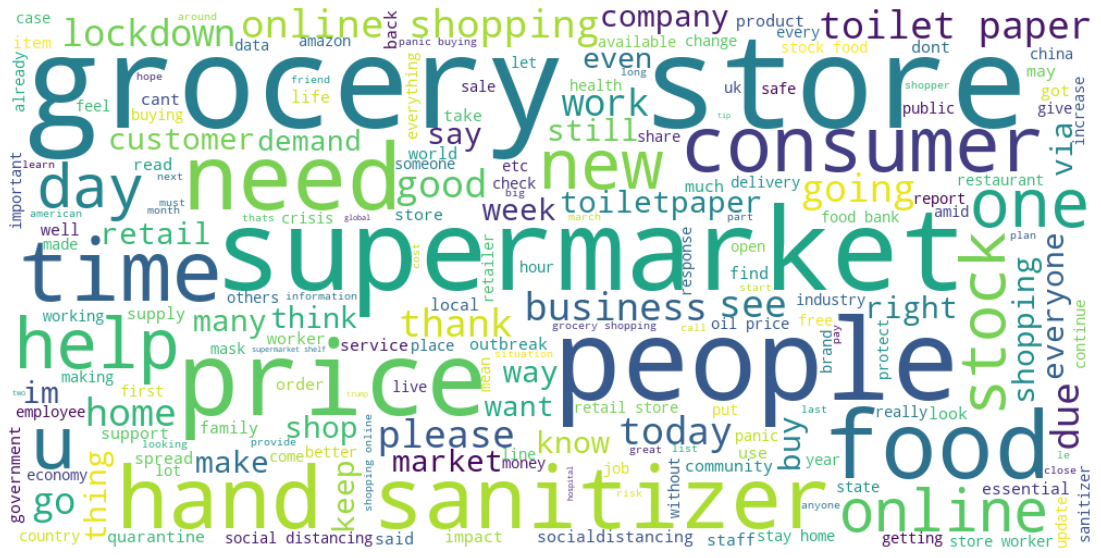

In [33]:
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                        random_state=random_state, relative_scaling=0.5).generate(' '.join(words_pos))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.grid(False)
plt.axis('off')
plt.show()

Again, there is not much difference between the overall word cloud and the word cloud for `Positive` sentiment. What about one example of the tweet?

In [34]:
df[df['Sentiment']=='Positive']['OriginalTweet'].iloc[1]

'Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P'

People/company are helping each other in order to fend off the spread of the virus especially to the elderly by giving dedicated time for them to do shopping.

Let's continue with the next few sentiments.

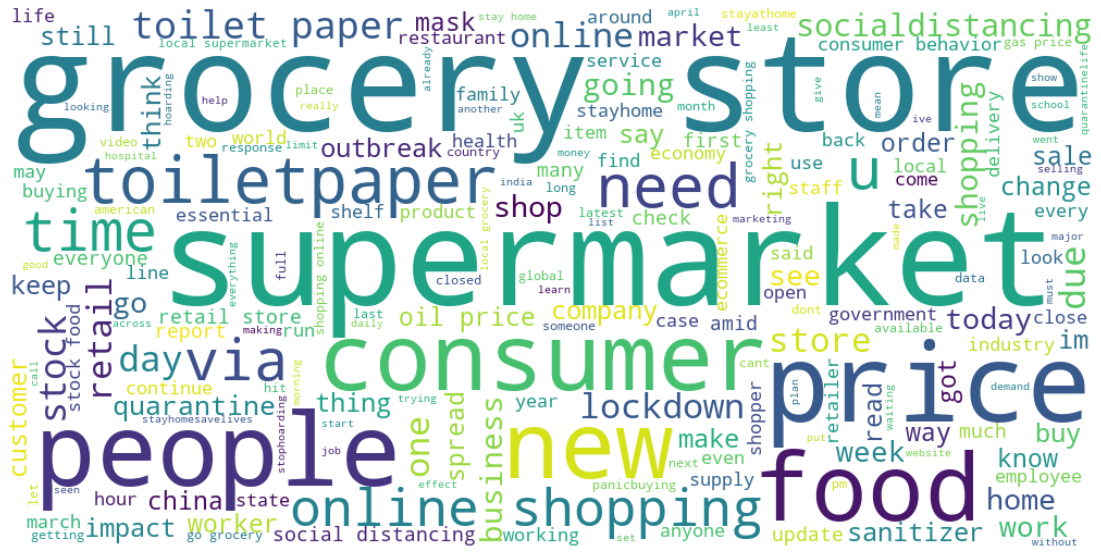

In [35]:
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                        random_state=random_state, relative_scaling=0.5).generate(' '.join(words_neu))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.grid(False)
plt.axis('off')
plt.show()

Again, `supermarket` and `grocery store` pop up again.

In [36]:
df[df['Sentiment']=='Neutral']['OriginalTweet'].iloc[1]

"Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ"

If we see the above tweet, subjectively the author feels that it should be a `Negative` one. Let's check the `Negative` word cloud.

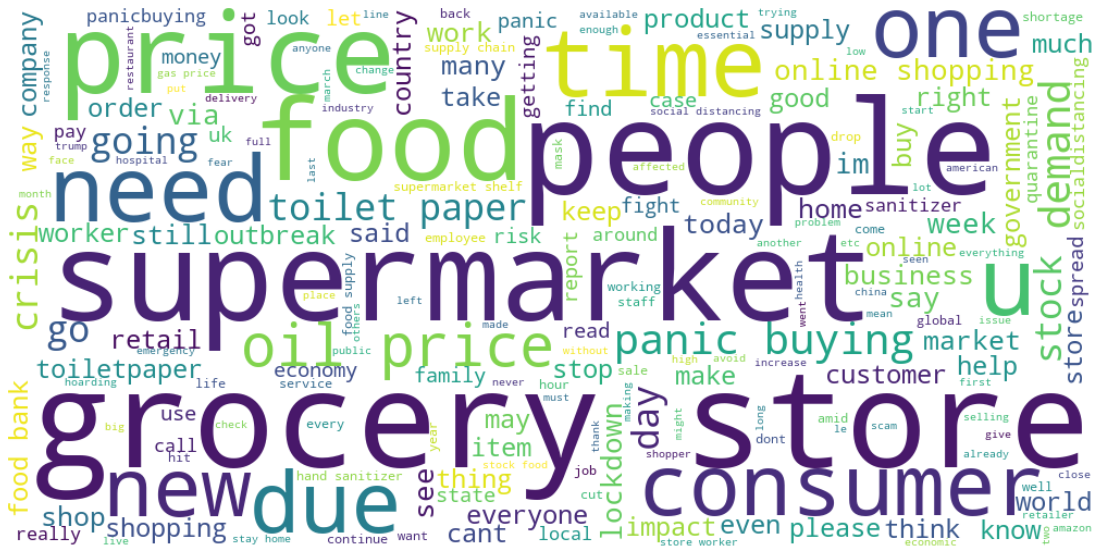

In [37]:
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                        random_state=random_state, relative_scaling=0.5).generate(' '.join(words_neg))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.grid(False)
plt.axis('off')
plt.show()

Same case as the other sentiments. Check the tweet.

In [38]:
df[df['Sentiment']=='Negative']['OriginalTweet'].iloc[1]

'@10DowningStreet @grantshapps what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checkout staff to police the actions of the selfish and profiteer'

Seems like the user is questioning what the company is doing to help reduce scalpers. It does fit to a `Negative` sentiment. Lastly let's check the `Extremely Negative` tweet.

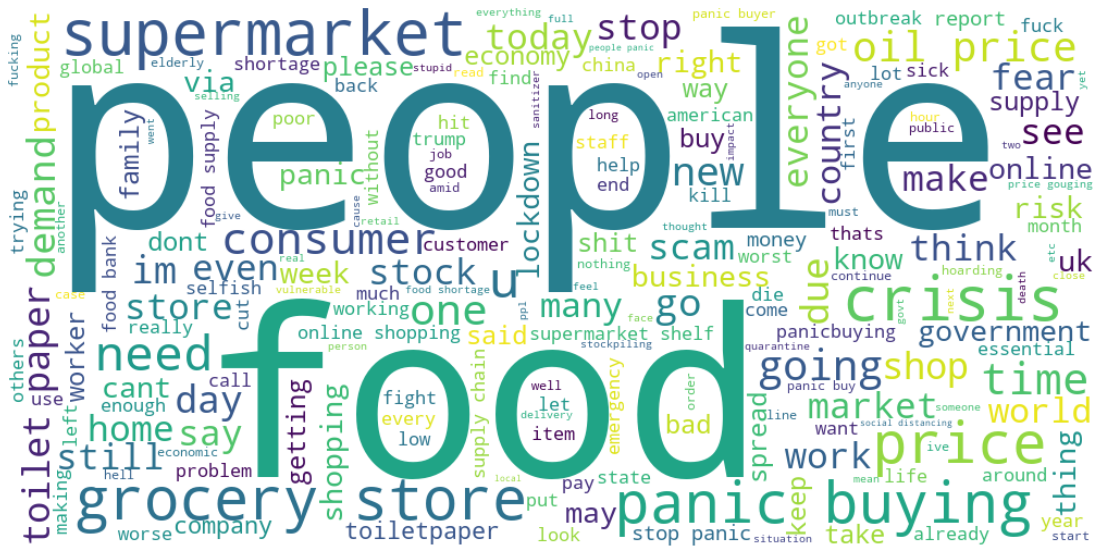

In [39]:
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                        random_state=random_state, relative_scaling=0.5).generate(' '.join(words_exneg))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.grid(False)
plt.axis('off')
plt.show()

The word `people` and `food` significantly pop up compared to the other word clouds. Let's see the tweet that belong to this category.

In [40]:
df[df['Sentiment']=='Extremely Negative']['OriginalTweet'].iloc[1]

'with 100  nations inficted with  covid  19  the world must  not  play fair with china  100 goverments must demand  china  adopts new guilde  lines on food safty  the  chinese  goverment  is guilty of  being  irosponcible   with life  on a global scale'

The user is demanding responsibility from the government of China with how they should regulate the food industry to prevent further tragey.

Since we have found out the most common words, let's check what is the most common stopwords in this dataset.

### 4.5. Most Common Stopwords

Let's repurpose the previous clean_text function to leave out only the stopwords.

In [41]:
def leave_stopwords(text):
    text = text.lower() #lowercase
    text = text.strip() #remove empty space
    text = re.sub(r'http\S+', '', text) #remove hyperlink
    text = re.sub(r'#', '', text) #remove only the hash but not the word tag
    text = re.sub(r'@\w+', '', text) #remove mention
    text = re.sub(r'\d+', '', text) #remove number
    text = re.sub(r'\n', ' ', text) #remove new line
    text = re.sub(r'\r', ' ', text) #remove carriage return
    text = re.sub(r'[^\x00-\x7f]', '', text) #remove non utf8/ascii characters
    text = text.split() #split to words
    text = ' '.join([word for word in text if word in stop_words]) #rejoin words without spec_words
    return text

Now we have the function, calculate the occurence for stopwords.

In [42]:
#collect the stopwords
words_stop = df['OriginalTweet'].apply(lambda x: leave_stopwords(x)).apply(nltk.word_tokenize)
words_stop = [x for x in words_stop for x in x]
words_stop = pd.DataFrame({'stopword': words_stop}).reset_index(drop=False).groupby('stopword').count().sort_values(by='index', ascending=False).reset_index()

Display the stopwords.

In [43]:
fig = px.treemap(words_stop, path=['stopword'], values='index', color='index', title='Stopword Count', width=1000, height=500).show()

The most common stopword is `the` followed by `to`. `the` can almost be placed anywhere in a sentence and that's why it is the most common stopword.

### 4.6. Most Common Punctuations

Now we will find out which puncuations occur the most in the dataset. To be fair, most tweets contain either link, hashtag, or mention. These three items each use certain punctuations and will definitely cause the count to bloat and for that reason we will filter links, hastags, and mentions as not to be counted for normal punctuations.

In [44]:
#define function to remove hyperlink, hashtag, and mention
def leave_punct(text):
    text = re.sub(r'http\S+', '', text) #remove hyperlink
    text = re.sub(r'#', '', text) #remove only the hash but not the word tag
    text = re.sub(r'@\w+', '', text) #remove mention
    text = re.sub(r'\d+', '', text) #remove number
    text = re.sub(r'\n', ' ', text) #remove new line
    text = re.sub(r'\r', ' ', text) #remove carriage return
    text = re.sub(r'[^\x00-\x7f]', '', text) #remove non utf8/ascii characters
    return text

#collect punctuation
punct_frame = df['OriginalTweet'].apply(lambda x: leave_punct(x))

In [45]:
#create empty dictionary to store word count and define the punctuations
punct_count = defaultdict(int)
punct = string.punctuation

#loop the whole tweets
for j in punct_frame:
    for i in j:
        if i in punct:
            punct_count[i] += 1

#transform to dataframe
punct_count = pd.DataFrame(punct_count.items(), columns=['punct', 'count']).sort_values(by='count', ascending=False).reset_index(drop=True)

Now let's plot the punctuation count.

In [46]:
fig = px.treemap(punct_count, path=['punct'], values='count', color='count', title='Punctuation Count', width=1000, height=500).show()

So period is the most common punctuation. Grammatically, period is only used at the end of the sentence, but then again this is a free for all social media which is not bound by grammar.

Let's see one example in which period is used not only at the end of the sentence.

In [47]:
print(df[df['OriginalTweet'].str.contains('....')]['OriginalTweet'][3])

My food stock is not the only one which is empty...

PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. 
Stay calm, stay safe.

#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j


On the first line we can see the user used `...` in which the usage often have multiple interpretation depending on the context of the tweet. It can be an unfinished thought or even just simple exasperation of the user to certain object and that's what make the period the most recurring punctuation.

### 4.7. Hashtag

Since the original bulk of the text have been explored, let's check the additional properties of the tweet which is hashtag. Hashtag usually correspond to the topic discussed in the tweet itself. Hashtag is constructed using # followed by either numbers or letters, but not punctuations nor whitespaces. If there is any punctuation or whitespace in the middle of the hashtag, the hashtag will only cover the string just before the punctuation or whitespace.

To understand it better, let's use some examples.

- #thisisconsideredhashtag
- #this/is/not/a/valid/hashtag
- #this_is_a_hashtag

So our current goal is to properly extract the hashtags and find out which ones are the most talked about.

In [48]:
#empty list to store the hashtag count
hashtag = []

#loop for every word in the tweets and store hashtag occurrence
for row in df['OriginalTweet']: #loop every document
    for word in row.split(): #loop every token
        if (re.match(r'#\w+', word)): #match token with hashtag format
            if re.sub(r'\d+','',word.translate(str.maketrans('', '', string.punctuation))).lower() not in spec_words: #make sure hashtag is not spec_words
                hashtag.append(word)

#transform to dataframe
hashtag = pd.DataFrame({'hashtag': hashtag}).reset_index(drop=False).groupby('hashtag').count().sort_values('index', ascending=False).reset_index()

Now that we have extracted the hashtags, let's plot them to find out which one is the most common hashtag.

In [49]:
fig = px.bar(hashtag[0:10], y='index', x='hashtag', title='Hashtag Count', width=1000, height=500)
fig.update_layout(yaxis_title="Count", xaxis_title="Hashtag")
fig.show()

Excluding the stopword hashtags, the most occuring hashtag is `#toiletpaper` and then followed by `#SocialDistancing`. If we look at the history of 2020, during the early stage of the outbreak people were panic buying and stocking up on toilet papers in the case they don't get to leave home due to prolonged lockdown. This led to shortages of toilet paper across the globe and led to this trending hashtag. Let's see one example of the hashtag `#toiletpaper` in the dataset.

In [50]:
print(df[df['OriginalTweet'].str.contains('#toiletpaper')]['OriginalTweet'].iloc[3])

For those in need of #toiletpaper try eBay.  You can get in bulk from us sellers for reasonable prices (just got 12 for 23 from a California seller) #coronapocolypse #COVID2019 your welcome


Our previous description held true for the hashtag `#toiletpaper`.

The next one is #SocialDistancing which was a new policy that was implemented to reduce the spread of the virus. Since at the start of the outbreak not much people were aware of how the virus was transmitted, this hashtag was used to inform/remind/encourage people to maintain social distancing. Let's check one example of the hashtag `#SocialDistancing` in the dataset.

In [51]:
print(df[df['OriginalTweet'].str.contains('#SocialDistancing')]['OriginalTweet'].iloc[0])

@drsanjaygupta @JohnBerman @NewDay all major businesses Trump touted saying they have supplies. Not really. Online ordering=no critical supplies avail. Online shopping is best for #SocialDistancing. Need help in that arena. Supplies via online. #coronavir


The above tweet is one of the tweets that contains the hashtag `#SocialDistancing` and used the hashtag `#SocialDistancing` to inform people to maintain social distancing.

In actual, there are many other tweets that use these hashtags out of context or even in negative `Sentiment`.

### 4.8. Mention

Let's check who gets mentioned the most during the timespan this dataset was taken on.

Just like before, we will reuse the code from hashtag to extract the mentions.

In [52]:
#empty list to store the hashtag count
mention = []

#loop for every word in the tweets and store mention occurrence
for row in df['OriginalTweet']: #loop every document
    for word in row.split(): #loop every token
        if (re.match(r'@\w+', word)): #match token with mention format
            mention.append(word)

#transform to dataframe
mention = pd.DataFrame({'mention': mention}).reset_index(drop=False).groupby('mention').count().sort_values('index', ascending=False).reset_index()

Now that we have the mentions, let's see who got mentioned the most.

In [53]:
fig = px.bar(mention[0:10], x='index', y='mention', title='Mention Count', width=1000, height=500)
fig.update_layout(xaxis_title="Count", yaxis_title="Mention")
fig.show()

The most mentioned person is `Donald Trump`, but then it's still around 250 tweets compared to the overall 45000 tweets.

If we group the top 10 mentioned accounts, we get to see that there are three account categories with the most mention:
- Leading figure: Donald Trump (President of USA), Boris Johnson (PM of UK), Narendra Modi/PMO India (PM of India) 
- Shopping venue: Tesco, Sainsbury's, Morrisons, Asda, Amazon
- Others: Youtube

The tweets surrounding leading figure will surely be about policy or responsibility to manage Covid-19 outbreak. While the tweets mentioning shopping avenue might be about panic buying and stock issue especially toilet paper and hand sanitizer. Lastly Youtube doesn't really make it to the context of Covid-19.

Let's take a look at some of the tweets.

In [54]:
print(df[df['OriginalTweet'].str.contains('realDonaldTrump')]['OriginalTweet'].iloc[0])

How come #TrumpIsAnIdiot or #trumpneedstoshutup is not trending?? For real!! People are freaked, stores canÂt keep food on their shelf, and the stock market is out of control. @realDonaldTrump please for the sake of the county shut up. #coronavirus


If we see the context of the above tweet, it's definitely a negative one or even an extremely negative one.

Let's check for the shopping venue and Youtube tweet.

In [55]:
print(df[df['OriginalTweet'].str.contains('@Tesco')]['OriginalTweet'].iloc[0])

@ASDA @Tesco @Morrisons @sainsburys donÂt you think itÂs about time you reduce your minimum online shopping basket from Â£40 as you donÂt have the product in stock that people need. I think you forgot about us single disabled people. Put your customers


As expected people were complaining about the stock issue due to panic buying.

Lastly let's find out which tweet mentioned YouTube.

In [56]:
print(df[df['OriginalTweet'].str.contains('@YouTube')]['OriginalTweet'].iloc[0])

Meanwhile In #Canada, Couple Cleans Out Entire #Meat Section Of Store! https://t.co/T897aWGGvk via @YouTube #hoarding   #coronavirus #nomestleft
#nofood
#canada
#panic


Looks like people were uploading videos of uproars to YouTube and then sharing it to twitter and that's what caused @YouTube to be in the top 10 most mentioned account.

### 4.9. Word Count

Lastly let's check the word count distribution based on each `Sentiment`.

Define function to clean the text and split into words but keeping the stopwords.

In [57]:
def create_corpus(text):
    text = text.lower() #lowercase
    text = re.sub(r'http\S+', '', text) #remove hyperlink
    text = re.sub(r'#', '', text) #remove only the hash but not the word tag
    text = re.sub(r'@\w+', '', text) #remove mention
    text = re.sub(r'\d+', '', text) #remove number
    text = re.sub(r'\n', ' ', text) #remove new line
    text = re.sub(r'\r', ' ', text) #remove carriage return
    text = re.sub(r'[^\x00-\x7f]', '', text) #remove non utf8/ascii characters
    text = text.translate(str.maketrans('', '', string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§')) #remove punctuation    
    text = text.strip() #remove empty space
    text = text.split() #split to words
    return text

Create new column to store the length of words in each tweet.

In [58]:
df['length'] = [word for word in df['OriginalTweet'].apply(lambda x: len(create_corpus(x)))]

Now let's see the distribution.

In [59]:
px.histogram(df, x='length', title='Tweet Length Distribution', width=1000, height=500).show()

It looks like there is a second peak in the histogram. A simple method to check would be to just recreate the histogram and showing the different sentiment on the plot.

In [60]:
px.histogram(df, x='length', title='Tweet Word Length Distribution', color='Sentiment', width=1000, height=500).show()

We found the cause of the second peak is the word `people`. It's primarily due to the `Neutral` tweets being skewed with the peak at 10 words. If we want to average out the word length, it would be around 30 words. Let's calculate the average word length.

In [61]:
df['length'].mean()

28.98812145478812

The average is 29 words, our guess if off just by a little bit. Take note that the average still includes stopwords.

### 4.10. Summary

Here are the summary of the whole EDA:
- Sentiment distribution is assumed to be balanced
- The locations with the most tweet count are `United States` and `United Kingdom` although the instances of the locations are separated into different cities or under other names (e.g. `London`, `London, England`, `United Kingdom`, and `UK`)
- The tweets regarding Covid-19 started gaining traction around 8 March 2020 and peaked on 20 March 2020 due to significant increase in the number of confirmed cases
- Some of the most common words are `grocery store`, `supermarket`, `hand sanitizer`, and `toilet paper` which represent the then state of panic in society due to low supply of toiletries and disease prevention items
- The most common stopwords are `the`, `to`, and `and`
- The most common punctuations are `.`, `,`, `?`
- The most common hashtag is `#toiletpaper` due to the poor availability back then, followed by `#SocialDistancing` as the newly implemented policy to reduce the spread of the virus, and `#panicbuying` as people were buying massive amount of goods to stock in their home in case they didn't get to leave home due to the lockdown
- There are three categories of most mentioned accounts: leading figure, shopping venue, and others (YouTube)
- The average tweet word length is 29 words including stopwords

## 5. Data Preprocessing

Before feeding the dataset into the model, let's do some preprocessing.

Subjectively, it's hard to see the difference between `Positive` and `Extremely Positive` or `Negative` and `Extremely Negative` tweets. For this model, we will simplify the categories to `Positive`, `Neutral`, and `Negative`.

In [62]:
df_train = data_train.copy()
df_test = data_test.copy()

In [63]:
df_train.replace({'Extremely Negative':'Negative', 'Extremely Positive':'Positive'}, inplace=True)
df_test.replace({'Extremely Negative':'Negative', 'Extremely Positive':'Positive'}, inplace=True)

In [64]:
px.pie(data_frame=df_train['Sentiment'].value_counts().to_frame().reset_index(), values='Sentiment', names='index', title='Sentiment', width=500, height=400, hole=0.5)

Next we will double the neutral tweets to match the number of positive tweets and negative tweets, then reshuffle the dataset.

In [65]:
df_train_new = pd.concat(
    [df_train, df_train[df_train['Sentiment']=='Neutral'].sample(frac=1, random_state=random_state)], axis=0
).sample(frac=1, random_state=random_state)

Let's recheck the sentiment distribution.

In [66]:
px.pie(data_frame=df_train_new['Sentiment'].value_counts().to_frame().reset_index(), values='Sentiment', names='index', title='Sentiment', width=500, height=400, hole=0.5)

Now the distribution looks more even compared to before.

### 5.1. Data Splitting

First off, split the train set to train set and validation set. We will set the split to stratify based on the target variable and then define the X and y variables.

In [67]:
train_df, val_df = train_test_split(df_train_new, test_size=0.1, random_state=random_state, stratify=df_train_new['Sentiment'])

X_train, y_train = train_df['OriginalTweet'], train_df['Sentiment']
X_val, y_val = val_df['OriginalTweet'], val_df['Sentiment']
X_test, y_test = df_test['OriginalTweet'], df_test['Sentiment']

Now we have all three sets ready, recheck the shape of all three sets.

In [68]:
train_df.shape, val_df.shape, df_test.shape

((43983, 6), (4887, 6), (3798, 6))

The validation set and test set sizes are roughly the same. Since we know from data loading that missing values are only present in `Location`, we won't make a separate section just to check it.

### 5.2. Text Cleaning

Text cleaning is the act of removing certain elements from the texts that will be fed to the model. There are many methods for text cleaning, but doing this may or may not cause the model to perform worse. 

See the tweet below for example.

In [69]:
"I don't live in a pineapple under the sea"

"I don't live in a pineapple under the sea"

So let's say we remove the stopwords `don't`. The above tweet will become:

In [70]:
clean_text("I don't live in a pineapple under the sea")

'live pineapple sea'

The context of the tweet changed significantly and the model might not be able to learn it.

However, if we choose not to remove the stopwords, the model will become too heavy since all the stopwords are in the corpus and the model might just learn unnecessary words for predicting the sentiment.

Let's say from the above tweet, the model might just predict the tweet as negative just from the following words:

In [71]:
"I don't live"

"I don't live"

As such the approach (to clean or not to clean the text) is dependent on the author and for this notebook, we will be doing the following:
- Lowercase
- Remove hyperlinks
- Remove mentions
- Remove numbers
- Remove new lines and carriage return
- Remove non ASCII characters
- Remove punctuations
- Lemmatize

But we will keep the stopwords.

In [72]:
corpus = set([lemmatizer.lemmatize(x) for x in X_train.apply(lambda x: create_corpus(x)) for x in x])

In [73]:
X_train_final = X_train.apply(lambda x: create_corpus(x)).apply(lambda x: [lemmatizer.lemmatize(x) for x in x])
X_train_final = X_train_final.apply(lambda x: ' '.join(x))

X_test_final = X_test.apply(lambda x: create_corpus(x)).apply(lambda x: [lemmatizer.lemmatize(x) for x in x])
X_test_final = X_test_final.apply(lambda x: ' '.join(x))

X_val_final = X_val.apply(lambda x: create_corpus(x)).apply(lambda x: [lemmatizer.lemmatize(x) for x in x])
X_val_final = X_val_final.apply(lambda x: ' '.join(x))

### 5.3. Target Labeling

In order to feed the label to the model, we will have to transform the string label to sparse matrix with each column representing one spectrum of `Sentiment`.

In [74]:
ohe = OneHotEncoder()

y_train_ohe = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_val_ohe = ohe.transform(y_val.values.reshape(-1,1)).toarray()
y_test_ohe = ohe.transform(y_test.values.reshape(-1,1)).toarray()

The target variable is ready to be fed into the model.

### 5.4. Preprocessing Pipeline

Save the preprocessing pipeline (OneHotEncoder for label) in case we need to use it somewhere else later.

In [75]:
# with open('label_ohe.pkl', 'wb') as f:
#     pickle.dump(ohe, f)

### 5.5. Tensorflow Input Pipeline

Create an input pipeline for tensorflow model. We will create dataset from slices of the input and then separate them into batches. We will also use prefetch so the next batches can be loaded first.

In [76]:
train_set = tf.data.Dataset.from_tensor_slices((X_train_final, y_train_ohe))
train_set = train_set.batch(int(X_train.shape[0]/10)).prefetch(2)

val_set = tf.data.Dataset.from_tensor_slices((X_val_final, y_val_ohe))
val_set = val_set.batch(int(X_val.shape[0]/10)).prefetch(2)

test_set = tf.data.Dataset.from_tensor_slices((X_test_final, y_test_ohe))
test_set = test_set.batch(int(X_test.shape[0]/10)).prefetch(2)

The batches have been created and we are finally ready to define the model.

## 6. Model Definition

For NLP, we will be using functional API to generate the model. The initial model that will be trained is the baseline model which will only consist of input layer, vectorization layer, embedding layer, GAP1D layer, and output layer. 

### 6.1. Early Stopping


We will also use EarlyStopping callback to stop training when the model doesn't improve so we can save time and work to improve on the model.

In [77]:
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    mode='min'
)

### 6.2. Text Vectorization

The vectorization layer will be used to convert each tweet into vector representation. The number of token will be half of the corpus length and the output sequence length will be the average word length of the tweet. We also won't be using ngrams for the base model.

Do note that vectorization will take the top <max_tokens> most frequent words.

Calculate the length of the corpus and take a half of the length as the max vocabulary length. This is an initial guess. The max_vocab_length can be as high as corpus length - 2.

In [78]:
corpus_length = int(len(list(corpus)))
max_vocab_length = int(corpus_length * 0.5)
corpus_length, max_vocab_length

(42285, 21142)

For the word length, we will use the average word length of the tweet in the train set. This is also an initial guess.

In [79]:
train_word_length = int(
    round(
        X_train_final.apply(lambda x: len(x.split())).mean(), 
    0)
)

train_word_length

28

Now let's define the vectorization layer. We won't be using ngrams for the base model.

In [80]:
textvect = TextVectorization(
    max_tokens=max_vocab_length,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=train_word_length
)

textvect.adapt(X_train_final)

### 6.3. Word Embedding

Now we will define the embedding layer. We will use the basic arguments of the embedding layer. The output dimension will be an initial guess. We will try with 2^6 for the dimension size and based on the resulting model, we can reduce it if the model overfits or increase it if the model underfits.

In [81]:
embedding = Embedding(
    input_dim=max_vocab_length,
    output_dim=64,
    embeddings_initializer='uniform',
    input_length=train_word_length
)

### 6.4. Layers

The input layer will be one dimensional since we only take tweet as the model input, while the output layer will have 3 nodes representing 3 sentiments. The base model will use SimpleRNN as the hidden layer.

The loss will be categorical crossentropy since we are using the softmax activation function for multiple output (more than two). The metrics used for the model will be accuracy.

Since the label is in sparse matrix format, we will use categorical accuracy just in case.

In [82]:
#functional model
inputs = Input(shape=(1,), dtype='string', name='input')
x = textvect(inputs)
x = embedding(x)
x = SimpleRNN(64)(x)
outputs = Dense(3, activation='softmax', name='output')(x)

model_nn = Model(inputs, outputs, name='nlp_fcn')

#compile
model_nn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

model_nn.summary()

Model: "nlp_fcn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 28)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 28, 64)            1353088   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 output (Dense)              (None, 3)                 195       
                                                                 
Total params: 1,361,539
Trainable params: 1,361,539
Non-trainable params: 0
_________________________________________________

## 7. Model Training

Train the models and save the loss and accuracy from each epoch.

In [83]:
EPOCHS = 30

model_nn_hist = model_nn.fit(
    train_set, 
    epochs=EPOCHS, 
    validation_data=val_set, 
    verbose=1, 
    callbacks=[earlystopping]
)

model_nn_metrics = pd.DataFrame(model_nn_hist.history)

Epoch 1/30
11/11 [==============================] - 3s 207ms/step - loss: 1.0588 - categorical_accuracy: 0.4312 - val_loss: 1.0187 - val_categorical_accuracy: 0.4672
Epoch 2/30
11/11 [==============================] - 2s 194ms/step - loss: 0.9561 - categorical_accuracy: 0.5546 - val_loss: 0.9888 - val_categorical_accuracy: 0.4954
Epoch 3/30
11/11 [==============================] - 2s 198ms/step - loss: 0.8635 - categorical_accuracy: 0.6239 - val_loss: 0.9117 - val_categorical_accuracy: 0.5854
Epoch 4/30
11/11 [==============================] - 2s 194ms/step - loss: 0.7009 - categorical_accuracy: 0.7309 - val_loss: 0.8120 - val_categorical_accuracy: 0.6501
Epoch 5/30
11/11 [==============================] - 2s 198ms/step - loss: 0.5337 - categorical_accuracy: 0.8093 - val_loss: 0.7789 - val_categorical_accuracy: 0.6877
Epoch 6/30
11/11 [==============================] - 2s 197ms/step - loss: 0.4080 - categorical_accuracy: 0.8662 - val_loss: 0.7033 - val_categorical_accuracy: 0.7240
Epoc

## 8. Model Evaluation

### 8.1. Baseline Model Evaluation

Let's plot the loss and accuracy of the model first to get a better grasp.

Make a general function for plotting first.

In [84]:
model_nn_metrics

loss  categorical_accuracy  val_loss  val_categorical_accuracy
0  1.058782              0.431167  1.018706                  0.467158
1  0.956104              0.554555  0.988777                  0.495396
2  0.863548              0.623900  0.911731                  0.585431
3  0.700857              0.730941  0.812029                  0.650092
4  0.533707              0.809313  0.778924                  0.687743
5  0.408041              0.866244  0.703332                  0.723962
6  0.314496              0.903690  0.658333                  0.748107
7  0.243703              0.931019  0.669717                  0.756497
8  0.206779              0.945956  0.743731                  0.759157

In [85]:
def plot_loss_acc(dataframe):
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(dataframe.index, dataframe['loss'], label='train')
    plt.plot(dataframe.index, dataframe['val_loss'], label='validation')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(dataframe.index, dataframe['categorical_accuracy'], label='train')
    plt.plot(dataframe.index, dataframe['val_categorical_accuracy'], label='validation')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.show()

Plot the loss and accuracy of the model.

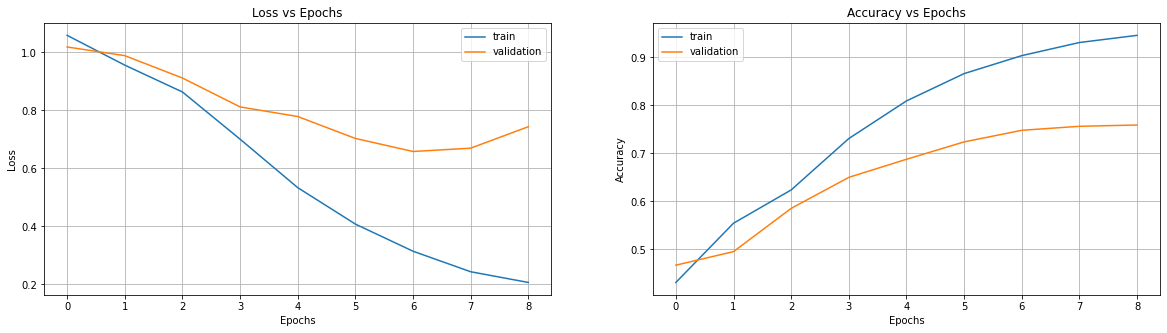

In [86]:
plot_loss_acc(model_nn_metrics)

If we look at the loss graph, our model is overfitting. The training loss keeps decreasing, while the validation loss starts by decreasing, hits inflection point and then keeps increasing. This happens because either one or more of the following:
- The model is too powerful
- The training data is not large enough to get a good generalization
- The training data has too many words that represent multiple sentiments

Let's check the classification report.

In [87]:
y_pred = [np.argmax(x) for x in model_nn.predict(train_set).tolist()]
print(classification_report([np.argmax(x) for x in y_train_ohe], y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90     13858
           1       0.97      0.95      0.96     13883
           2       0.91      0.92      0.92     16242

    accuracy                           0.92     43983
   macro avg       0.92      0.92      0.92     43983
weighted avg       0.92      0.92      0.92     43983



In [88]:
y_pred = [np.argmax(x) for x in model_nn.predict(test_set).tolist()]
print(classification_report([np.argmax(x) for x in y_test_ohe], y_pred))

              precision    recall  f1-score   support

           0       0.67      0.68      0.67      1633
           1       0.52      0.47      0.49       619
           2       0.65      0.68      0.67      1546

    accuracy                           0.64      3798
   macro avg       0.62      0.61      0.61      3798
weighted avg       0.64      0.64      0.64      3798



The model really performs poorly if we see the classification report. Even random guessing will be slightly better  on the test set.

For now we will try to make the model less powerful by changing the architecture.

### 8.2. Model Improvement: LSTM/GRU

Now we will use LSTM/GRU layer to check if there is any improvement in the model.

Define and train LSTM model.

In [89]:
#functional model
inputs = Input(shape=(1,), dtype='string', name='input')
x = textvect(inputs)
x = embedding(x)
x = LSTM(64)(x)
outputs = Dense(3, activation='softmax', name='output')(x)

model_lstm = Model(inputs, outputs, name='nlp_lstm')

#compile
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

model_lstm.summary()

Model: "nlp_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 28)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 28, 64)            1353088   
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 output (Dense)              (None, 3)                 195       
                                                                 
Total params: 1,386,307
Trainable params: 1,386,307
Non-trainable params: 0
________________________________________________

In [90]:
model_lstm_hist = model_lstm.fit(
    train_set, 
    epochs=EPOCHS, 
    validation_data=val_set, 
    verbose=1, 
    callbacks=[earlystopping]
)

model_lstm_metrics = pd.DataFrame(model_lstm_hist.history)

Epoch 1/30
11/11 [==============================] - 7s 491ms/step - loss: 1.0865 - categorical_accuracy: 0.4392 - val_loss: 1.0644 - val_categorical_accuracy: 0.4751
Epoch 2/30
11/11 [==============================] - 5s 468ms/step - loss: 1.0412 - categorical_accuracy: 0.4740 - val_loss: 1.0132 - val_categorical_accuracy: 0.4805
Epoch 3/30
11/11 [==============================] - 5s 467ms/step - loss: 0.9911 - categorical_accuracy: 0.4952 - val_loss: 0.9641 - val_categorical_accuracy: 0.5187
Epoch 4/30
11/11 [==============================] - 5s 460ms/step - loss: 0.8645 - categorical_accuracy: 0.6113 - val_loss: 0.8981 - val_categorical_accuracy: 0.5652
Epoch 5/30
11/11 [==============================] - 5s 477ms/step - loss: 0.7117 - categorical_accuracy: 0.6672 - val_loss: 0.7627 - val_categorical_accuracy: 0.6720
Epoch 6/30
11/11 [==============================] - 5s 459ms/step - loss: 0.5465 - categorical_accuracy: 0.7810 - val_loss: 0.7214 - val_categorical_accuracy: 0.7260
Epoc

Define and train GRU model.

In [91]:
#functional model
inputs = Input(shape=(1,), dtype='string', name='input')
x = textvect(inputs)
x = embedding(x)
x = GRU(64)(x)
outputs = Dense(3, activation='softmax', name='output')(x)

model_gru = Model(inputs, outputs, name='nlp_gru')

#compile
model_gru.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

model_gru.summary()

Model: "nlp_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 28)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 28, 64)            1353088   
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 output (Dense)              (None, 3)                 195       
                                                                 
Total params: 1,378,243
Trainable params: 1,378,243
Non-trainable params: 0
_________________________________________________

In [92]:
model_gru_hist = model_gru.fit(
    train_set, 
    epochs=EPOCHS, 
    validation_data=val_set, 
    verbose=1, 
    callbacks=[earlystopping]
)

model_gru_metrics = pd.DataFrame(model_gru_hist.history)

Epoch 1/30
11/11 [==============================] - 7s 467ms/step - loss: 1.0809 - categorical_accuracy: 0.4517 - val_loss: 1.0569 - val_categorical_accuracy: 0.4692
Epoch 2/30
11/11 [==============================] - 5s 444ms/step - loss: 1.0389 - categorical_accuracy: 0.4707 - val_loss: 1.0210 - val_categorical_accuracy: 0.4774
Epoch 3/30
11/11 [==============================] - 5s 428ms/step - loss: 1.0021 - categorical_accuracy: 0.4822 - val_loss: 1.0051 - val_categorical_accuracy: 0.4979
Epoch 4/30
11/11 [==============================] - 5s 448ms/step - loss: 0.9714 - categorical_accuracy: 0.5373 - val_loss: 0.9682 - val_categorical_accuracy: 0.5359
Epoch 5/30
11/11 [==============================] - 5s 427ms/step - loss: 0.8687 - categorical_accuracy: 0.6054 - val_loss: 0.8524 - val_categorical_accuracy: 0.6530
Epoch 6/30
11/11 [==============================] - 5s 422ms/step - loss: 0.6795 - categorical_accuracy: 0.7376 - val_loss: 0.7715 - val_categorical_accuracy: 0.7209
Epoc

Now let's compare the loss and accuracy graph of the three models.

SimpleRNN

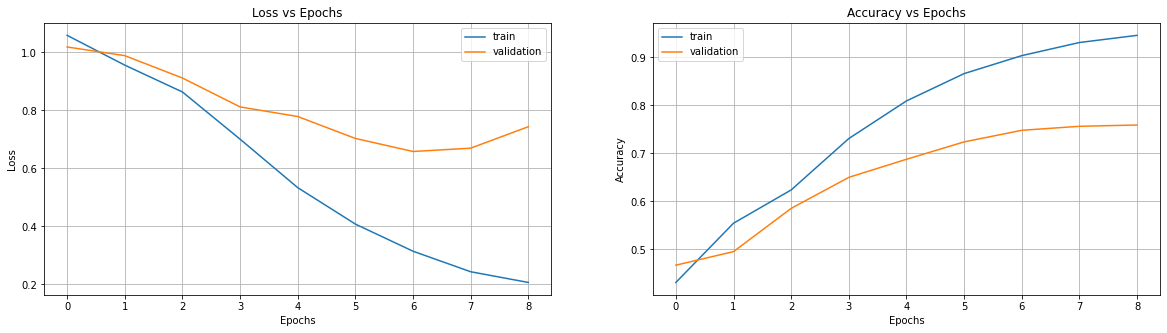

In [93]:
plot_loss_acc(model_nn_metrics)

LSTM

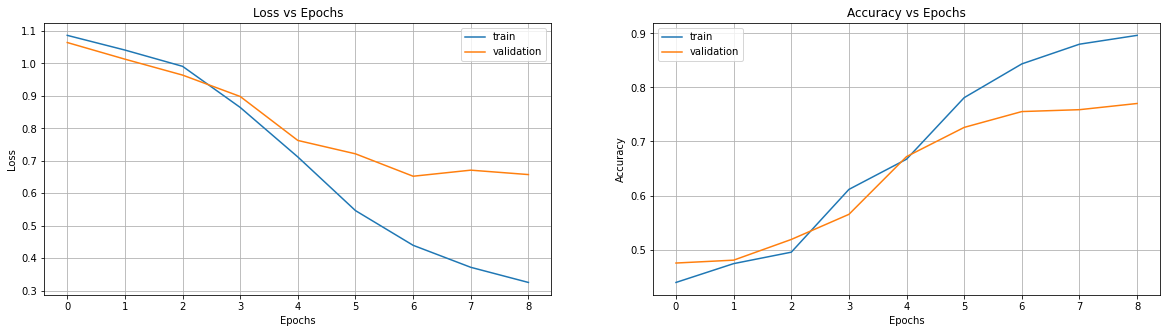

In [94]:
plot_loss_acc(model_lstm_metrics)

GRU

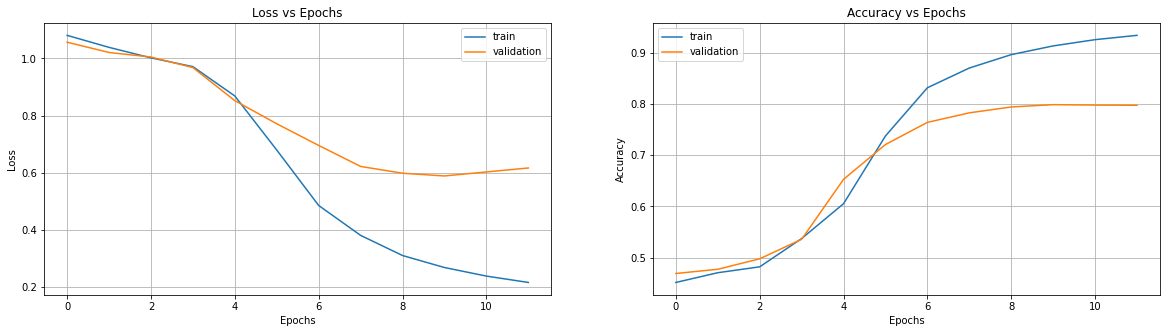

In [95]:
plot_loss_acc(model_gru_metrics)

Looking at the loss graphs, all three models are overfitting. If we look at the accuracy graph, GRU has the highest out of all three. So moving on we will use the GRU model and tweak it further.

Another thing to note here is GRU somehow having longer execution time than LSTM, even though LSTM has more complex architecture, GRU has two gates, while LSTM three. But then if we see the epochs, the GRU model progress to longer epochs and that's maybe the reason why the GRU model takes longer to run.

### 8.3. Model Improvement: Reducing Hidden Neuron

First off we will try reducing the number of hidden neurons. We will reduce it to the square root of the previous GRU model.

In [96]:
#functional model
inputs = Input(shape=(1,), dtype='string', name='input')
x = textvect(inputs)
x = embedding(x)
x = GRU(8)(x)
outputs = Dense(3, activation='softmax', name='output')(x)

model_gru_red = Model(inputs, outputs, name='nlp_gru')

#compile
model_gru_red.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

model_gru_red.summary()

Model: "nlp_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 28)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 28, 64)            1353088   
                                                                 
 gru_1 (GRU)                 (None, 8)                 1776      
                                                                 
 output (Dense)              (None, 3)                 27        
                                                                 
Total params: 1,354,891
Trainable params: 1,354,891
Non-trainable params: 0
_________________________________________________

Train the model.

In [97]:
model_gru_red_hist = model_gru_red.fit(
    train_set, 
    epochs=EPOCHS, 
    validation_data=val_set, 
    verbose=1, 
    callbacks=[earlystopping]
)

model_gru_red_metrics = pd.DataFrame(model_gru_red_hist.history)

Epoch 1/30
11/11 [==============================] - 3s 169ms/step - loss: 1.0987 - categorical_accuracy: 0.3266 - val_loss: 1.0852 - val_categorical_accuracy: 0.4614
Epoch 2/30
11/11 [==============================] - 2s 145ms/step - loss: 1.0767 - categorical_accuracy: 0.4707 - val_loss: 1.0692 - val_categorical_accuracy: 0.4723
Epoch 3/30
11/11 [==============================] - 2s 142ms/step - loss: 1.0594 - categorical_accuracy: 0.4802 - val_loss: 1.0549 - val_categorical_accuracy: 0.4774
Epoch 4/30
11/11 [==============================] - 2s 141ms/step - loss: 1.0434 - categorical_accuracy: 0.4871 - val_loss: 1.0420 - val_categorical_accuracy: 0.4809
Epoch 5/30
11/11 [==============================] - 2s 144ms/step - loss: 1.0289 - categorical_accuracy: 0.4961 - val_loss: 1.0314 - val_categorical_accuracy: 0.4856
Epoch 6/30
11/11 [==============================] - 2s 142ms/step - loss: 1.0161 - categorical_accuracy: 0.5074 - val_loss: 1.0231 - val_categorical_accuracy: 0.4891
Epoc

Now let's compare the loss and accuracy graph of the GRU models.

Initial GRU Model

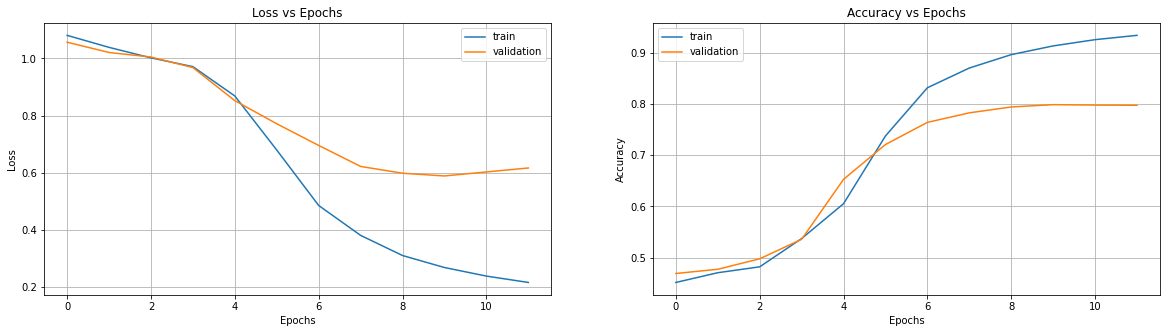

In [98]:
plot_loss_acc(model_gru_metrics)

Reduced GRU Model

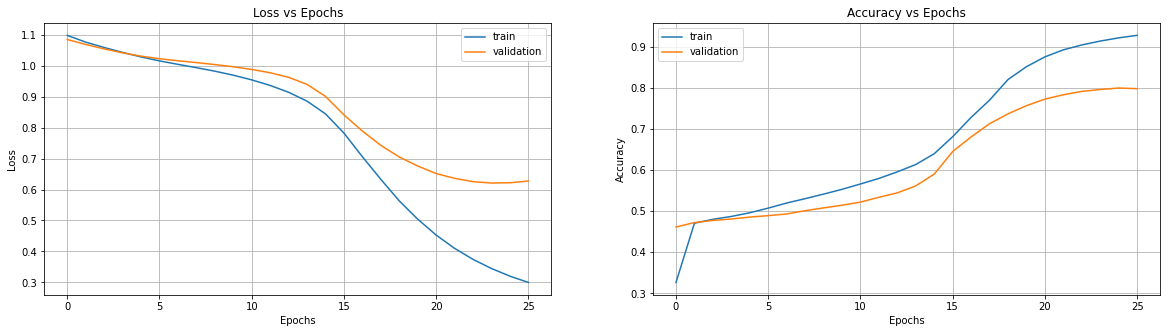

In [99]:
plot_loss_acc(model_gru_red_metrics)

Looks like we managed to stop before the model overfits, however there is not much improvement in the accuracy, although there is slight decrease (~20 seconds) in the training time even with more epochs.

Moving on, we will use the model with reduced neurons and introduce dropout.

### 8.4. Model Improvement: Dropout

We will use 20% dropout rate before GRU layer and see the change first.

In [100]:
#functional model
inputs = Input(shape=(1,), dtype='string', name='input_gru')
x = textvect(inputs)
x = embedding(x)
x = Dropout(0.2)(x)
x = GRU(8)(x)
outputs = Dense(3, activation='softmax', name='output_gru')(x)

model_gru_do = Model(inputs, outputs, name='nlp_gru')

#compile
model_gru_do.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

model_gru_do.summary()

Model: "nlp_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_gru (InputLayer)      [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 28)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 28, 64)            1353088   
                                                                 
 dropout (Dropout)           (None, 28, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 8)                 1776      
                                                                 
 output_gru (Dense)          (None, 3)                 27        
                                                           

In [101]:
model_gru_do_hist = model_gru_do.fit(
    train_set, 
    epochs=EPOCHS, 
    validation_data=val_set, 
    verbose=1, 
    callbacks=[earlystopping]
)

model_gru_do_metrics = pd.DataFrame(model_gru_do_hist.history)

Epoch 1/30
11/11 [==============================] - 3s 209ms/step - loss: 1.1075 - categorical_accuracy: 0.3072 - val_loss: 1.0884 - val_categorical_accuracy: 0.3745
Epoch 2/30
11/11 [==============================] - 2s 176ms/step - loss: 1.0782 - categorical_accuracy: 0.4515 - val_loss: 1.0684 - val_categorical_accuracy: 0.4846
Epoch 3/30
11/11 [==============================] - 2s 179ms/step - loss: 1.0564 - categorical_accuracy: 0.4900 - val_loss: 1.0516 - val_categorical_accuracy: 0.4837
Epoch 4/30
11/11 [==============================] - 2s 177ms/step - loss: 1.0369 - categorical_accuracy: 0.4938 - val_loss: 1.0369 - val_categorical_accuracy: 0.4864
Epoch 5/30
11/11 [==============================] - 2s 178ms/step - loss: 1.0191 - categorical_accuracy: 0.4989 - val_loss: 1.0241 - val_categorical_accuracy: 0.4895
Epoch 6/30
11/11 [==============================] - 2s 181ms/step - loss: 1.0031 - categorical_accuracy: 0.5088 - val_loss: 1.0136 - val_categorical_accuracy: 0.4950
Epoc

Let's check the result.

Reduced GRU

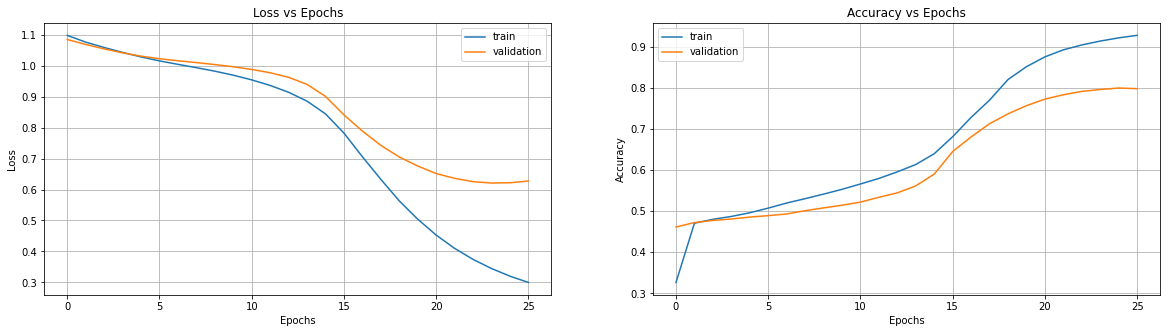

In [102]:
plot_loss_acc(model_gru_red_metrics)

GRU with Dropout

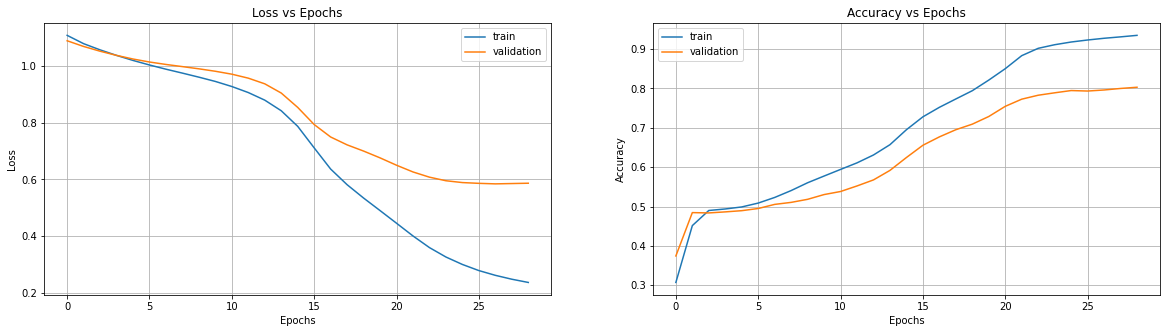

In [103]:
plot_loss_acc(model_gru_do_metrics)

Here we see that the accuracy is just slightly higher than the previous model, roughly 1% difference at most. The dropout model also reached early stopping at lesser epoch than the other.

Let's try adding additional dropout layer after GRU layer.

In [104]:
#functional model
inputs = Input(shape=(1,), dtype='string', name='input')
x = textvect(inputs)
x = embedding(x)
x = Dropout(0.2)(x)
x = GRU(8)(x)
x = Dropout(0.05)(x)
outputs = Dense(3, activation='softmax', name='output')(x)

model_gru_ddo = Model(inputs, outputs, name='nlp_gru')

#compile
model_gru_ddo.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

model_gru_ddo.summary()

Model: "nlp_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 28)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 28, 64)            1353088   
                                                                 
 dropout_1 (Dropout)         (None, 28, 64)            0         
                                                                 
 gru_3 (GRU)                 (None, 8)                 1776      
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                           

In [105]:
model_gru_ddo_hist = model_gru_ddo.fit(
    train_set, 
    epochs=EPOCHS, 
    validation_data=val_set, 
    verbose=1, 
    callbacks=[earlystopping]
)

model_gru_ddo_metrics = pd.DataFrame(model_gru_ddo_hist.history)

Epoch 1/30
11/11 [==============================] - 4s 209ms/step - loss: 1.0535 - categorical_accuracy: 0.4683 - val_loss: 1.0413 - val_categorical_accuracy: 0.4735
Epoch 2/30
11/11 [==============================] - 2s 184ms/step - loss: 1.0280 - categorical_accuracy: 0.4826 - val_loss: 1.0270 - val_categorical_accuracy: 0.4774
Epoch 3/30
11/11 [==============================] - 2s 186ms/step - loss: 1.0111 - categorical_accuracy: 0.4918 - val_loss: 1.0173 - val_categorical_accuracy: 0.4852
Epoch 4/30
11/11 [==============================] - 2s 183ms/step - loss: 0.9969 - categorical_accuracy: 0.5041 - val_loss: 1.0089 - val_categorical_accuracy: 0.4950
Epoch 5/30
11/11 [==============================] - 2s 187ms/step - loss: 0.9828 - categorical_accuracy: 0.5240 - val_loss: 1.0005 - val_categorical_accuracy: 0.5042
Epoch 6/30
11/11 [==============================] - 2s 182ms/step - loss: 0.9671 - categorical_accuracy: 0.5462 - val_loss: 0.9913 - val_categorical_accuracy: 0.5124
Epoc

Reduced GRU

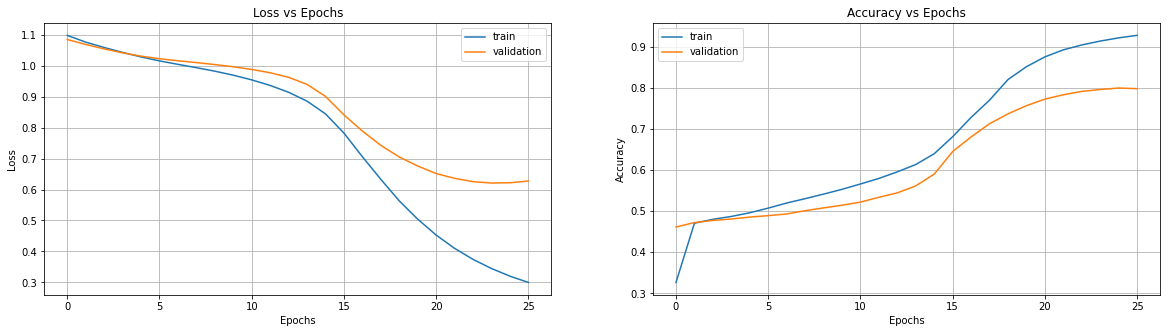

In [106]:
plot_loss_acc(model_gru_red_metrics)

GRU with Dropout

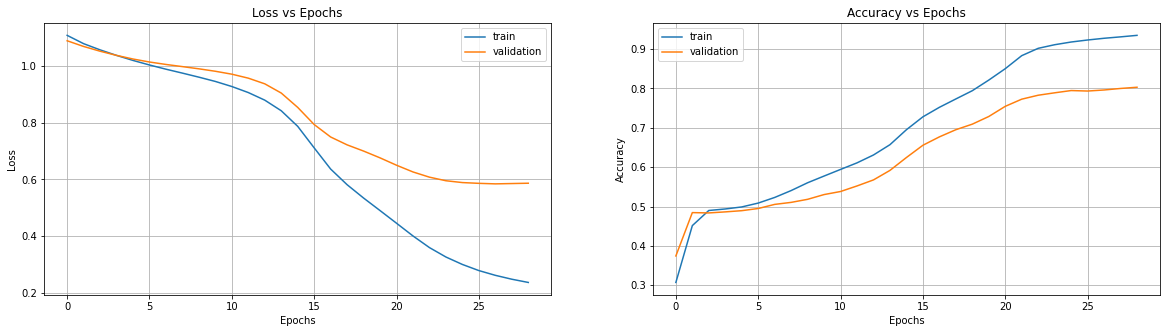

In [107]:
plot_loss_acc(model_gru_do_metrics)

GRU with Multi Dropout

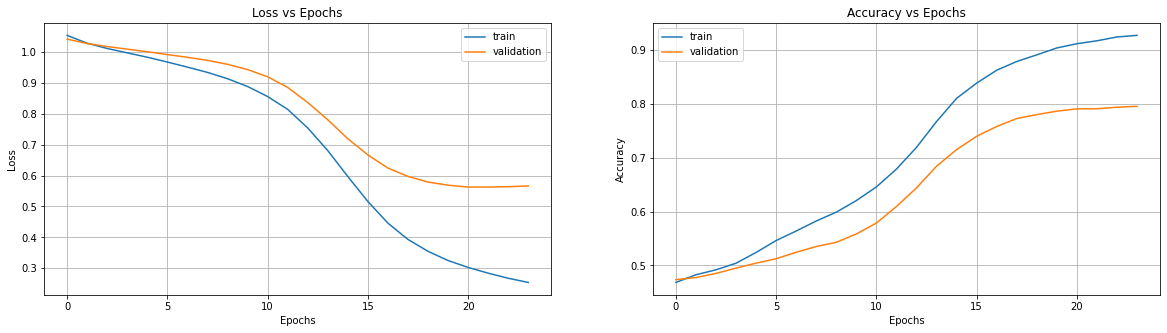

In [108]:
plot_loss_acc(model_gru_ddo_metrics)

Looks like adding another dropout layer doesn't help much. The number of epochs increased but personally there is no improvement at all. We will use the model with only one dropout layer because with the same accuracy, it has lower validation loss compared to the reduced GRU model.

### 8.5. Model Analysis

Now from the accuracy graph we know that this model has some problem with generalization due to the dataset. This conclusion is taken after modifying the architecture several times but the accuracy difference still persists. If we test the model on the test set, it definitely will suffer from the same problem just like the validation set.

Strictly speaking, architecture won't help much with the model accuracy at this point.

See the classification report below.

Train Classification Report

In [109]:
y_pred = [np.argmax(x) for x in model_gru_red.predict(train_set).tolist()]
print(classification_report([np.argmax(x) for x in y_train_ohe], y_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88     13858
           1       0.82      0.92      0.87     13883
           2       0.97      0.74      0.84     16242

    accuracy                           0.86     43983
   macro avg       0.87      0.87      0.86     43983
weighted avg       0.88      0.86      0.86     43983



Since we duplicated the neutral tweets, the model can predict them better as a result on the trainset. Let's see the classification report for the test set.

Test Classification Report

In [110]:
y_pred = [np.argmax(x) for x in model_gru_red.predict(test_set).tolist()]
print(classification_report([np.argmax(x) for x in y_test_ohe], y_pred))

              precision    recall  f1-score   support

           0       0.71      0.83      0.76      1633
           1       0.45      0.62      0.52       619
           2       0.81      0.54      0.65      1546

    accuracy                           0.68      3798
   macro avg       0.66      0.66      0.64      3798
weighted avg       0.71      0.68      0.68      3798



As expected the model performs poorly especially on the neutral tweets.

As have been discussed earlier, the performance of the model is based on two things: the architecture and the dataset. Now from our trial, even at the most simple architecture the model still performs poorly on the validation set. The performance doesn't change much after more modifications, the generalization gap still exists.

The problem is very likely due to the data set itself. Now strictly speaking, Twitter is a free space where people can type anything they want. Now this pose several problems to our model:
1. The use of non-standard words, slang or just simple typo, make the corpus size becomes bloated which results in the accummulation of junk words that are not useful for our model
2. Now if we have a larger dataset, the previous problem might be irrelevant to us. But since the number of tweets (roughly 45,000 tweets) is almost equal to the size of the corpus (roughly 42,000 words), the model fails to map certain words or phrases to the right sentiment
3. And comes our last problem, the sentiment itself is full of subjectivity. In actual it would be difficult to determine if something is negative/positive or neutral. Moreover if sarcasm is mixed in

Now, what to do from here on?

Since we hit a dead end modifying the architecture, here are some future improvements/modifications that can be done:
- Modify text cleaning method or even leave the text as it is
- Vary the hyperparameter of text vectorization and embedding (especially dimension size/corpus length and/or average word/sequence length)
- Use pretrained model (Word2Vec, FastText, GloVe)

Now about the architecture.

In general, GRU model wins over LSTM model on smaller dataset because faster training time and more or less same accuracy. This is achieved by the use of two gates in GRU without memory unit, while LSTM won over on larger dataset and longer sequence due to the use of memory unit.

Architecturally the GRU is also simpler in processing which information is going to be kept in the long term memory and thus easier to modify.

### 8.6. Model Saving

Save the model.

In [111]:
# model_gru_do.save('tensormodel', save_traces=True)

We can ignore the warning.

## 9. Model Inference

Do an inference using the model that have been developed. Create an entry for prediction.

In [112]:
input_text = [
    "dying alone due to covid",
    "late for work due to reduced availability of transportation since the outbreak",
    "covid enables me to work from home which is a blessing in disguise"
]

Load the model.

In [113]:
from tensorflow.keras.models import load_model
saved_model = load_model('tensormodel')

OSError: No file or directory found at tensormodel

Predict the result.

In [ ]:
sentiment = {0: 'negative', 1: 'neutral', 2: 'positive'}

for tweet in input_text:
    print('The tweet:')
    print('"',tweet, '"\n\ris a', sentiment[(saved_model.predict([tweet]).argmax(axis=1))[0]], 'tweet\n')

We successfully predicted the sentiment of the tweets.

## 10. Conclusion

Based on the analysis and modeling that have been done, we can conclude the followings:

1. The target is balanced at the original distribution, but becomes imbalanced when the extreme sentiment is merged to the non-extreme counterpart roughly 2:1:2 ratio for negative:neutral:positive
2. Here are what can be concluded from EDA:
    - Sentiment distribution is assumed to be balanced
    - The locations with the most tweet count are `United States` and `United Kingdom` although the instances of the locations are separated into different cities or under other names (e.g. `London`, `London, England`, `United Kingdom`, and `UK`)
    - The tweets regarding Covid-19 started gaining traction around 8 March 2020 and peaked on 20 March 2020 due to significant increase in the number of confirmed cases
    - Some of the most common words are `grocery store`, `supermarket`, `hand sanitizer`, and `toilet paper` which represent the then state of panic in society due to low supply of toiletries and disease prevention items
    - The most common stopwords are `the`, `to`, and `and`
    - The most common punctuations are `.`, `,`, `?`
    - The most common hashtag is `#toiletpaper` due to the poor availability back then, followed by `#SocialDistancing` as the newly implemented policy to reduce the spread of the virus, and `#panicbuying` as people were buying massive amount of goods to stock in their home in case they didn't get to leave home due to the lockdown
    - There are three categories of most mentioned accounts: leading figure, shopping venue, and others (YouTube)
    - The average tweet word length is 29 words including stopwords
3. During preprocessing, the text is cleaned, but the stopwords are kept. The following cleaning methods were done on the text:
    - Lowercase
    - Remove hyperlinks
    - Remove mentions
    - Remove numbers
    - Remove new lines and carriage return
    - Remove non ASCII characters
    - Remove punctuations
    - Lemmatize
3. The baseline model is constructed using:
    - Earlystopping with patience of 2 epochs to prevent overfitting
    - Textvectorization with half of the corpus length as the max token length and the average word length as the sequence length
    - Embedding layer with 64 output dimension size
    - SimpleRNN layer with 64 output dimension size
    - Output layer with softmax for three categories
4. Improvements are done on the model with the final model changes the following architecture:
    - GRU is used instead of SimpleRNN
    - The neuron size is reduced from 64 to 8
    - A dropout layer with 20% rate is added before the GRU layer
5. GRU model has simpler architecture than LSTM and results in shorter training time at the same epoch with more or less the same accuracy. However for longer sequence, LSTM model tends to be better due to the use of memory unit
6. The resulting model has high accuracy for training set, but performs poorly on the validation set and worse on the test set. Several possible causes:
    - The use of non-standard words
    - Small dataset compared to corpus size
    - Sentiment labeling is subjective 
7. Further improvement that can be done:
    - Modify text cleaning method or even leave the text as it is
    - Vary the hyperparameter of text vectorization and embedding (especially dimension size/corpus length and/or average word/sequence length)
    - Use pretrained model (Word2Vec, FastText, GloVe)